Libraries

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import joblib

sns.set(style='whitegrid')


Data loading

In [2]:

df = pd.read_excel("../data/Copy of loan.xlsx")
df.head()


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


initial Inspection

In [3]:
print(df.shape)

(614, 13)


In [4]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [5]:

df.describe().T

,count,mean,std,min,25%,50%,75%,max
ApplicantIncome,614.0,5403.459283,6109.041673,150.0,2877.5,3812.5,5795.00,81000.0
CoapplicantIncome,614.0,1621.245798,2926.248369,0.0,0.0,1188.5,2297.25,41667.0
LoanAmount,592.0,146.412162,85.587325,9.0,100.0,128.0,168.00,700.0
Loan_Amount_Term,600.0,342.000000,65.120410,12.0,360.0,360.0,360.00,480.0
Credit_History,564.0,0.842199,0.364878,0.0,1.0,1.0,1.00,1.0


Data Cleaning and Pre-processing

In [6]:

df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [7]:
df['Gender'] = df['Gender'].fillna(df['Gender'].mode()[0])
df['Married'] = df['Married'].fillna(df['Married'].mode()[0])
df['Self_Employed'] = df['Self_Employed'].fillna(df['Self_Employed'].mode()[0])
df['Dependents'] = df['Dependents'].fillna(df['Dependents'].mode()[0])

df['LoanAmount'] = df['LoanAmount'].fillna(df['LoanAmount'].mean())

# Create log transformed column first
df['LoanAmount_log'] = np.log1p(df['LoanAmount'])

# Then fill missing values if any
df['LoanAmount_log'] = df['LoanAmount_log'].fillna(df['LoanAmount_log'].mean())

df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0])
df['Credit_History'] = df['Credit_History'].fillna(df['Credit_History'].mode()[0])


Number of people who take loan grouped by gender:
Gender
Male      502
Female    112
Name: count, dtype: int64


<Axes: xlabel='Gender', ylabel='count'>

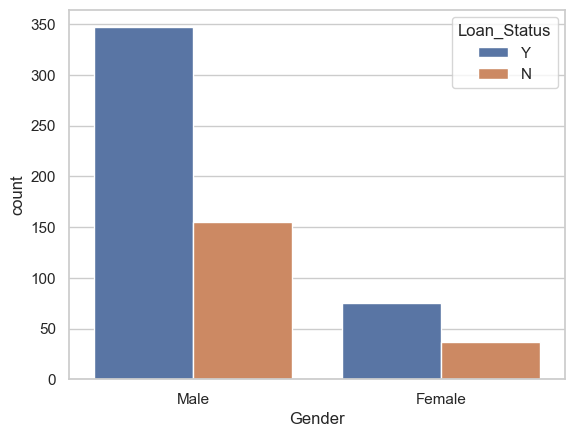

In [8]:
print("Number of people who take loan grouped by gender:")
print(df['Gender'].value_counts())

sns.countplot(x='Gender', data=df, hue='Loan_Status')


Number of people who take loan grouped by marital status:
Married
Yes    401
No     213
Name: count, dtype: int64


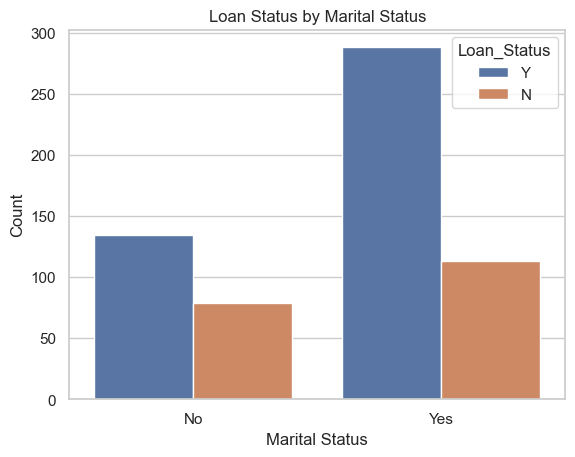

In [9]:
print("Number of people who take loan grouped by marital status:")
print(df['Married'].value_counts())

sns.countplot(x='Married', data=df, hue='Loan_Status')
plt.title("Loan Status by Marital Status")
plt.xlabel("Marital Status")
plt.ylabel("Count")
plt.show()


Number of people who take loan grouped by Dependancy:
Dependents
0     360
1     102
2     101
3+     51
Name: count, dtype: int64


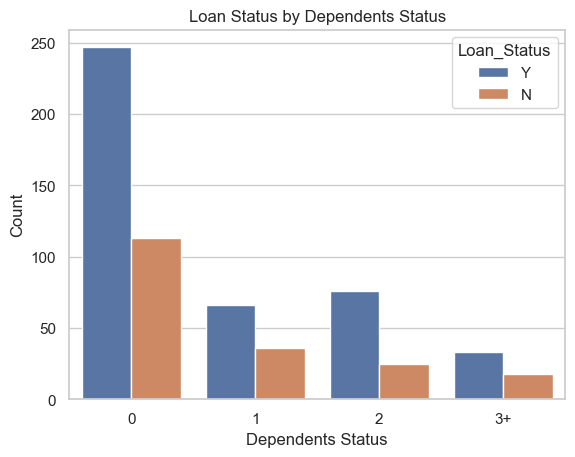

In [10]:
print("Number of people who take loan grouped by Dependancy:")
print(df['Dependents'].value_counts())

sns.countplot(x='Dependents', data=df, hue='Loan_Status')
plt.title("Loan Status by Dependents Status")
plt.xlabel("Dependents Status")
plt.ylabel("Count")
plt.show()


Number of people who take loan grouped by Self_Employed:
Self_Employed
No     532
Yes     82
Name: count, dtype: int64


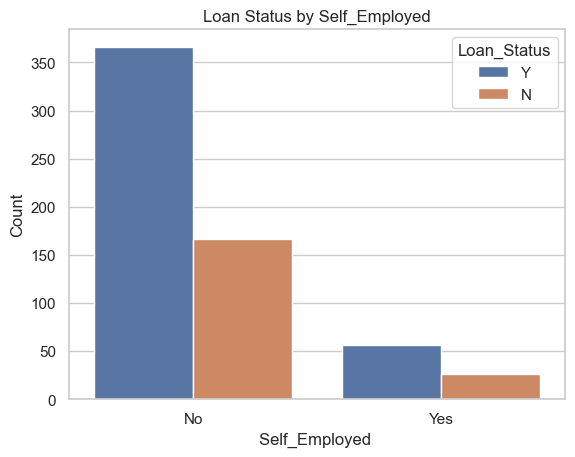

In [11]:
print("Number of people who take loan grouped by Self_Employed:")
print(df['Self_Employed'].value_counts())

sns.countplot(x='Self_Employed', data=df, hue='Loan_Status')
plt.title("Loan Status by Self_Employed")
plt.xlabel("Self_Employed ")
plt.ylabel("Count")
plt.show()

number of people who take loan as group by loan amount:
LoanAmount
146.412162    22
120.000000    20
110.000000    17
100.000000    15
187.000000    12
              ..
292.000000     1
142.000000     1
350.000000     1
496.000000     1
253.000000     1
Name: count, Length: 204, dtype: int64


C:\Users\Dell\AppData\Local\Temp\ipykernel_16388\56286228.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='LoanAmount', data=df, palette='Set1')


<Axes: xlabel='LoanAmount', ylabel='count'>

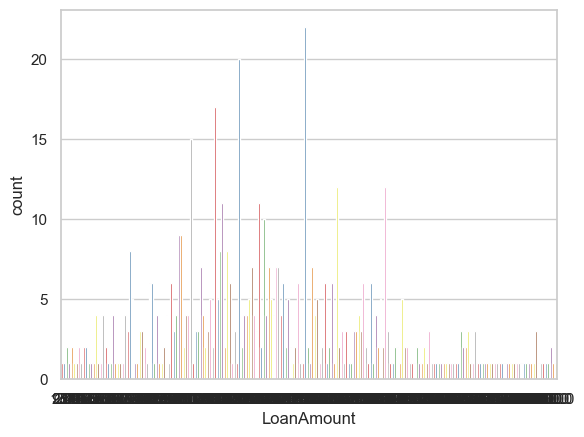

In [12]:
print("number of people who take loan as group by loan amount:")
print(df['LoanAmount'].value_counts())
sns.countplot(x='LoanAmount', data=df, palette='Set1')

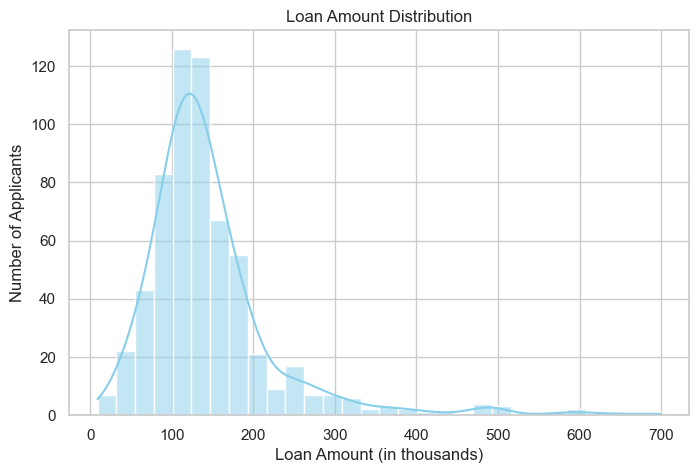

In [13]:
plt.figure(figsize=(8,5))
sns.histplot(df['LoanAmount'], bins=30, kde=True, color='skyblue')
plt.title("Loan Amount Distribution")
plt.xlabel("Loan Amount (in thousands)")
plt.ylabel("Number of Applicants")
plt.show()


In [14]:
df.columns = df.columns.str.strip()


Number of people who take loan grouped by Credit History:
Credit_History
1.0    525
0.0     89
Name: count, dtype: int64


C:\Users\Dell\AppData\Local\Temp\ipykernel_16388\2792823178.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Credit_History', data=df, palette='Set1')


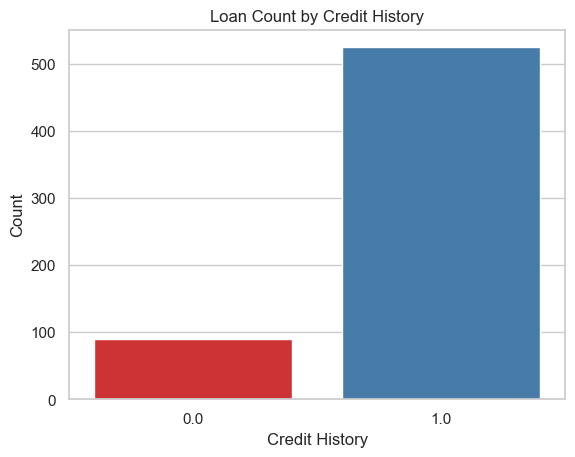

In [15]:
print("Number of people who take loan grouped by Credit History:")
print(df['Credit_History'].value_counts())

sns.countplot(x='Credit_History', data=df, palette='Set1')
plt.title("Loan Count by Credit History")
plt.xlabel("Credit History")
plt.ylabel("Count")
plt.show()


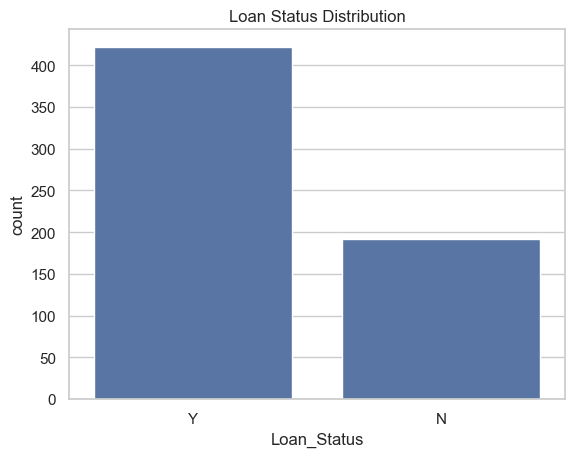

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='Loan_Status', data=df)
plt.title('Loan Status Distribution')
plt.show()


In [17]:
df.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status',
       'LoanAmount_log'],
      dtype='object')

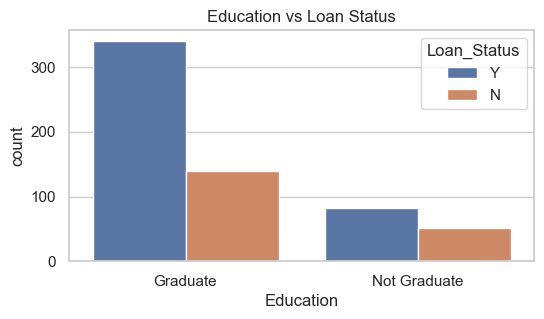

In [18]:
cat_cols = ['Education']

for col in cat_cols:
    plt.figure(figsize=(6, 3))
    sns.countplot(x=col, hue='Loan_Status', data=df)
    plt.title(f'{col} vs Loan Status')
    plt.show()


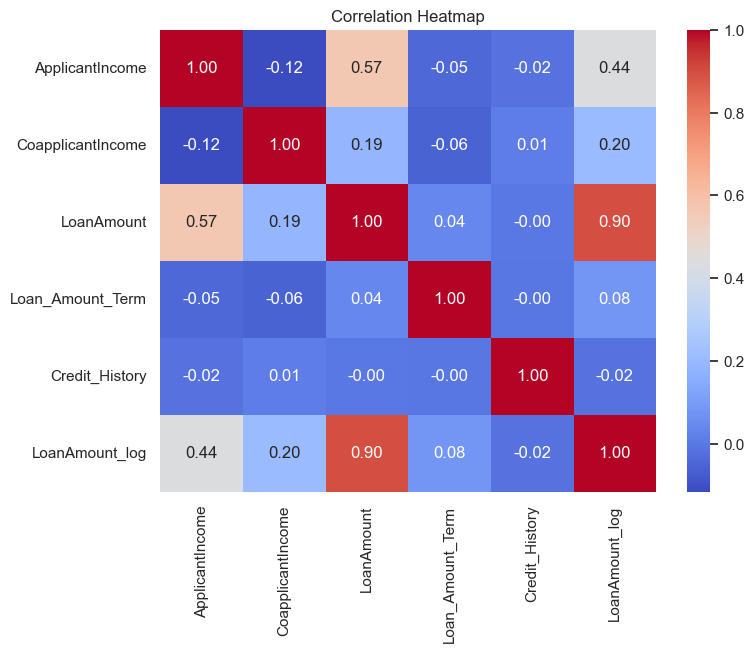

In [19]:
plt.figure(figsize=(8, 6))
numeric_df = df.select_dtypes(include=[np.number]) 
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()



Feature Engineering

In [20]:

df['Dependents'] = pd.to_numeric(df['Dependents'].replace('3+', 3))

C:\Users\Dell\AppData\Local\Temp\ipykernel_16388\121573937.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Dependents'] = pd.to_numeric(df['Dependents'].replace('3+', 3))


<Axes: >

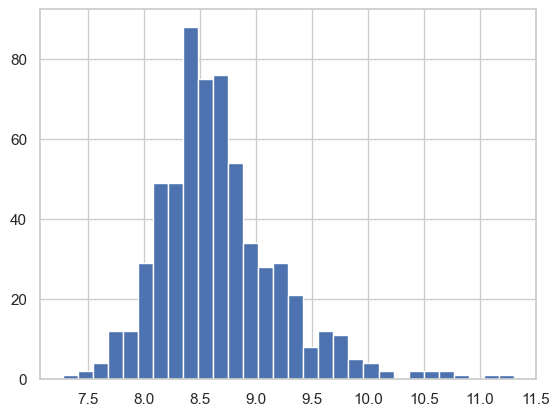

In [21]:

df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
df['TotalIncome_log'] = np.log(df['TotalIncome'])
df['TotalIncome_log'].hist(bins=30)


In [22]:
# Log-transform numerical features to handle skewness
df['ApplicantIncome_log'] = np.log(df['ApplicantIncome'])
df['CoapplicantIncome_log'] = np.log(df['CoapplicantIncome'] + 1) 
df['LoanAmount_log'] = np.log(df['LoanAmount'])
df['Loan_Amount_Term_log'] = np.log(df['Loan_Amount_Term'])
df['TotalIncome_log'] = np.log(df['TotalIncome'])

In [23]:

df.drop(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'TotalIncome'], axis=1, inplace=True)

Label Encode the Target Variable

In [24]:
le_target = LabelEncoder()
df['Loan_Status'] = le_target.fit_transform(df['Loan_Status'])

In [25]:

X = df.drop(['Loan_ID', 'Loan_Status'], axis=1)
y = df['Loan_Status']

Train-Test Split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [27]:
print(X_train.columns.tolist())


['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area', 'LoanAmount_log', 'TotalIncome_log', 'ApplicantIncome_log', 'CoapplicantIncome_log', 'Loan_Amount_Term_log']


 Encode Categorical Features in Train and Test (using LabelEncoder column-wise)
python
Copy code


In [28]:

#  categorical columns
cat_cols = X_train.select_dtypes(include=['object']).columns


le = LabelEncoder()

# Encode categorical columns
for col in cat_cols:
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))


    

Feature Scaling

In [29]:
from sklearn.preprocessing import LabelEncoder

cat_cols = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']

le = LabelEncoder()

for col in cat_cols:
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))



In [30]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Model Training and Evaluation

In [31]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

In [32]:
from sklearn import metrics

y_pred = rf_clf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred) 
print('Accuracy of Random Forest Classifier is {:.2%}'.format(accuracy))

y_pred

Accuracy of Random Forest Classifier is 77.24%


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [33]:
from sklearn.naive_bayes import GaussianNB

nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train)

GaussianNB()

In [34]:
from sklearn import metrics

y_pred = nb_clf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred) 

print('Accuracy of GaussianNB is {:.2%}'.format(accuracy))
y_pred


Accuracy of GaussianNB is 78.05%


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])

In [35]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [36]:
y_pred = dt_clf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy of DT is {:.2%}'.format(accuracy))
y_pred



Accuracy of DT is 68.29%


array([1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0])

In [37]:
from sklearn.neighbors import KNeighborsClassifier

kn_clf = KNeighborsClassifier()
kn_clf.fit(X_train, y_train)

KNeighborsClassifier()

In [38]:
y_pred = kn_clf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy of knn is {:.2%}'.format(accuracy))
y_pred

Accuracy of knn is 73.17%


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [39]:

from sklearn.svm import SVC

svm_clf = SVC()  
svm_clf.fit(X_train, y_train)

SVC()

In [40]:
y_pred = svm_clf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy of svm is {:.2%}'.format(accuracy))
y_pred

Accuracy of svm is 65.04%


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [41]:

from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(max_iter=1000)  
log_clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [42]:
y_pred = log_clf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy of svm is {:.2%}'.format(accuracy))
y_pred

Accuracy of svm is 78.86%


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

 model comparison


Logistic Regression:
              precision    recall  f1-score   support

           0       0.95      0.42      0.58        43
           1       0.76      0.99      0.86        80

    accuracy                           0.79       123
   macro avg       0.85      0.70      0.72       123
weighted avg       0.83      0.79      0.76       123

Confusion Matrix:
 [[18 25]
 [ 1 79]]

Random Forest:
              precision    recall  f1-score   support

           0       0.78      0.42      0.55        43
           1       0.75      0.94      0.83        80

    accuracy                           0.76       123
   macro avg       0.77      0.68      0.69       123
weighted avg       0.76      0.76      0.73       123

Confusion Matrix:
 [[18 25]
 [ 5 75]]

SVM:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        43
           1       0.65      1.00      0.79        80

    accuracy                           0.65       123
   macro

C:\Users\Dell\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Dell\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Dell\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

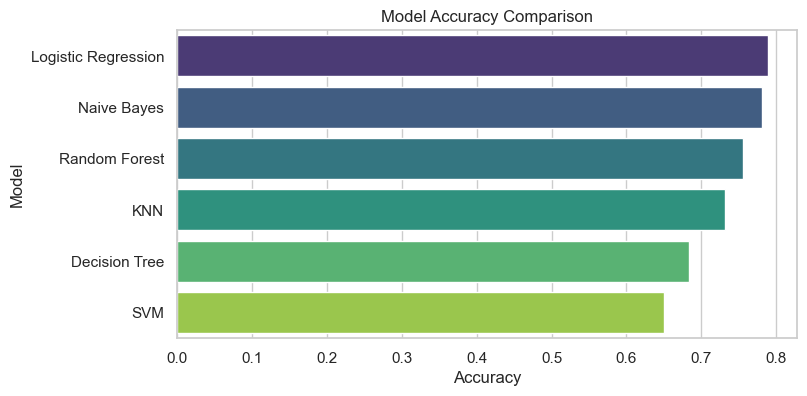

In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier()
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1
    })
    print(f"\n{name}:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
print("\nModel Comparison:")
print(results_df)


plt.figure(figsize=(8,4))
sns.barplot(x="Accuracy", y="Model", data=results_df, palette="viridis")
plt.title("Model Accuracy Comparison")
plt.show()


In [44]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(),
    "Gaussian NB": GaussianNB(),
    "Random Forest": RandomForestClassifier()
}

cv_results = []

for model_name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    cv_results.append({
        "Model": model_name,
        "Mean Accuracy": scores.mean(),
        "Std Dev": scores.std()
    })

cv_df = pd.DataFrame(cv_results).sort_values(by="Mean Accuracy", ascending=False)

print(cv_df)



                 Model  Mean Accuracy   Std Dev
0  Logistic Regression       0.814595  0.021301
2          Gaussian NB       0.800371  0.018144
3        Random Forest       0.794166  0.045306
1                  SVM       0.696537  0.003958


Hyperparameter tuning

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs'],
    'penalty': ['l2'] 
}

log_reg = LogisticRegression(max_iter=1000)

grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)


Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best Cross-Validation Accuracy: 0.8145949288806431


Final model

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import joblib


final_model = LogisticRegression(max_iter=1000)
final_model.fit(X_train, y_train)


y_pred_final = final_model.predict(X_test)


print("Final Model Performance on Test Data:")
print(classification_report(y_test, y_pred_final))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_final))






Final Model Performance on Test Data:
              precision    recall  f1-score   support

           0       0.95      0.42      0.58        43
           1       0.76      0.99      0.86        80

    accuracy                           0.79       123
   macro avg       0.85      0.70      0.72       123
weighted avg       0.83      0.79      0.76       123

Confusion Matrix:
 [[18 25]
 [ 1 79]]


In [47]:
joblib.dump(final_model, 'logistic_regression_final_model.pkl')

['logistic_regression_final_model.pkl']